In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as op

In [2]:
data = np.loadtxt("data/kic11754974_lc.txt")
fulltimes = data[:, 0] # days
tmid = 0.5*(fulltimes[0] + fulltimes[-1])
times = fulltimes - tmid
dmmags = data[:, 1] * 1000. # mmags
metadata = np.loadtxt("data/kic11754974_metadata.csv", delimiter=",", skiprows=1)
tdelay = np.loadtxt("data/kic11754974_unwrapped_time_delay.csv", delimiter=",", skiprows=1)
tdzero = float(next(open("data/kic11754974_unwrapped_time_delay.csv")))
tdtime = tdelay[:,0] + tdzero
tdtau = tdelay[:,1] / 86400
tdunc = tdelay[:,2] / 86400

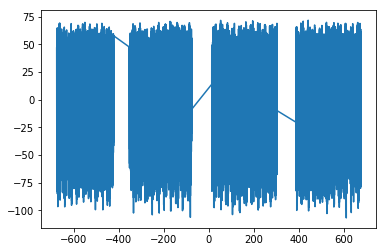

In [3]:
plt.plot(times,dmmags)

<Container object of 3 artists>

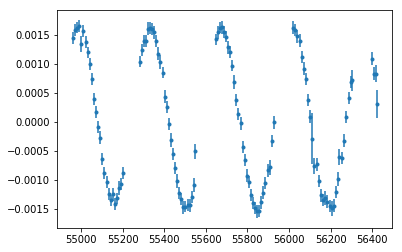

In [4]:
plt.errorbar(tdtime,tdtau,tdunc,fmt=".")

In [5]:
nu_arr = metadata[::6]
nu_arr

array([ 16.34475466,  21.39900267])

In [6]:
orbits = pd.read_csv("data/orbits.csv").rename(columns = lambda x: x.strip())

In [7]:
orbits.columns

Index(['Name', 'Porb', 'Porb_sig_p', 'Porb_sig_m', 'a1sini/c',
       'a1sini/c_sig_p', 'a1sini/c_sig_m', 'e', 'e_sig_p', 'e_sig_m', 'phip',
       'phip_sig_p', 'phip_sig_m', 'varpi', 'varpi_sig_p', 'varpi_sig_m',
       'f(M)Msun', 'f(M)Msun_sig_p', 'f(M)Msun_sig_m', 'gradient',
       'grad_sig_p', 'grad_sig_m', 't_p', 't_p_sig_p', 't_p_sig_m', 'K1_ms',
       'K1_ms_sig_p', 'K1_ms_sig_m', 'median_segment_size'],
      dtype='object')

In [8]:
orb_params = orbits[orbits.Name == "kic11754974"].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"]
tp = orb_params["t_p"] - tmid
a1d = a1/86400.0

In [9]:
def get_tau(times, porb, a1d, tp):
    return -a1d * np.sin(2 * np.pi * (times - tp)/ porb)
    
def get_design_matrix(times, nu_arr, porb, a1d, tp):
    tau = get_tau(times, porb, a1d, tp)
    arg = 2 * np.pi * nu_arr[None, :] * (times - tau)[:, None]
    N_nu = len(nu_arr)
    D = np.empty((len(times),2*N_nu))
    D[:,:N_nu] = np.cos(arg)
    D[:,N_nu:] = np.sin(arg)
    return D

In [10]:
def get_W_hat(D, dmmags):
    return np.linalg.solve(np.dot(D.T, D), np.dot(D.T, dmmags))

In [11]:
D = get_design_matrix(times, nu_arr, porb, a1d, tp)

Compute the coefficients A\_i, B\_i from A\_i cos (omega(t-tau)) + B\_i sin (omega(t-tau))

Stored in W_hat as [A\_1, A\_2, ..., A\_N, B\_1, B\_2, ..., B\_N]

In [12]:
W_hat = get_W_hat(D, dmmags)
W_hat

array([-42.41623506,  -6.9087101 ,  30.23294418,  -8.57395724])

In [13]:
def chisq(times, dmmags, nu_arr, porb, a1d, tp):
    D = get_design_matrix(times, nu_arr, porb, a1d, tp)
    W_hat = get_W_hat(D, dmmags)
    model = np.dot(D, W_hat)
    chi_sq = np.sum((model - dmmags)**2) # no sigma yet
    return chi_sq

In [14]:
chisq(times, dmmags, nu_arr, porb, a1d, tp)

5326599.0934297284

In [15]:
t0s = tp + np.linspace(0, porb,500)
chisqs = np.empty_like(t0s)
for i, t0 in enumerate(t0s):
    chisqs[i] = chisq(times, dmmags, nu_arr, porb, a1d, t0)

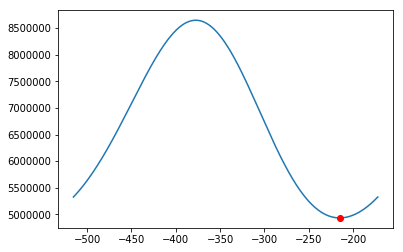

In [16]:
plt.plot(t0s, chisqs)
ind = np.argmin(chisqs)
plt.plot(t0s[ind], chisqs[ind], "or")

In [17]:
nus = np.linspace(16, 17, 500)
chisqs = np.empty_like(nus)
for i, nu_something in enumerate(nus):
    chisqs[i] = chisq(times, dmmags, nu_something, porb, a1d, tp)

IndexError: invalid index to scalar variable.

In [ ]:
plt.plot(nus, chisqs)
ind = np.argmin(chisqs)
plt.plot(nus[ind], chisqs[ind], "or")

In [ ]:
nus[ind]-nu

In [ ]:
plt.plot(times+tmid, get_tau(times, porb, a1d, tp))
plt.plot(times+tmid, get_tau(times, porb+1, a1d, tp))

In [ ]:
periods = porb + np.linspace(-50, 50,1000)
chisqs = np.empty_like(periods)
for i, period in enumerate(periods):
    chisqs[i] = chisq(times, dmmags, nu_arr, period, a1d, tp)

In [ ]:
plt.plot(periods, chisqs)
ind = np.argmin(chisqs)
plt.plot(periods[ind], chisqs[ind], "or")

In [ ]:
def objective(orbparams, times, dmmags, nu_arr):
    return chisq(times, dmmags, nu_arr, *orbparams)

In [ ]:
init = [porb, a1d, tp]
soln = op.minimize(objective, init, args=(times, dmmags, nu_arr))
soln

In [ ]:
plt.plot(times+tmid, get_tau(times, porb, a1d, tp))
plt.plot(times+tmid, get_tau(times, *(soln.x)))
plt.errorbar(tdtime,tdtau,tdunc,fmt=".")